Function: Mul(Add(Sin(1.2530876630670413, 1.5977271060894922), Add(Sin(0.5744252828845774, 0.8660485365679639), Mul(Sin(0.34583752129989664, 1.3404924384108292), Lin(-0.3299034234615701, 0.8822709821555109), 3), 5), 7), Lin(0.7203450113255527, 0.3172289418963904), 9)


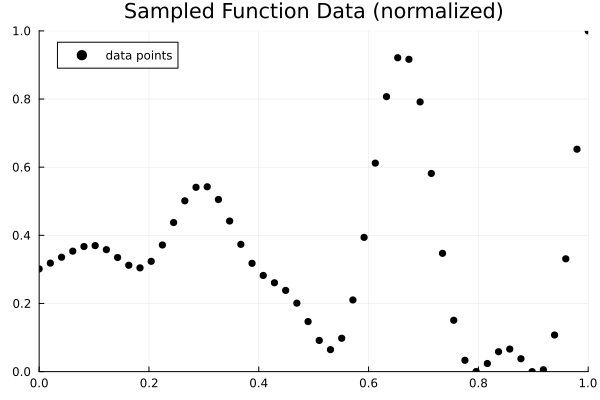

In [18]:
using Gen
using Plots

include("../src/inference/particle_filter.jl")
include("../src/data_gen.jl")

fn = function_prior();
xs, ys, fn, (xmin_orig, xmax_orig) = get_data(fn, 50);
println("Function: ", fn)
scatter(xs, ys, xlims=(0, 1), ylims=(0, 1), 
        title="Sampled Function Data (normalized)", label="data points", color="black")


[ Info: Saved animation to /Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif


Plots.AnimatedGif("/Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif")
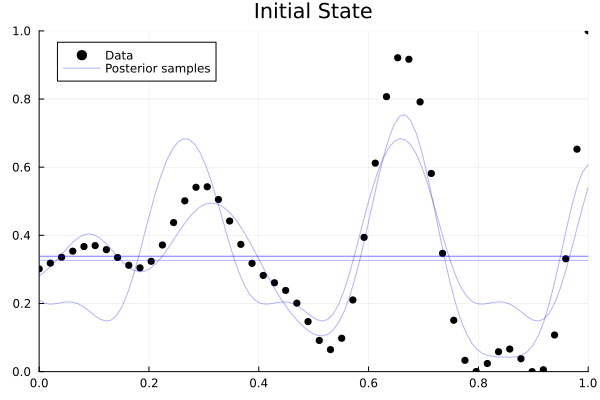

In [19]:
include("../src/covariance.jl")

function plot_posterior_samples(traces, xs, ys; title="", xlims=nothing, ylims=nothing)
    # Set default limits if not provided
    if xlims === nothing
        xlims = (minimum(xs), maximum(xs))
    end
    if ylims === nothing
        ylims = (0, 1)
    end
    
    p = scatter(xs, ys, label="Data", color=:black, markersize=4, 
                xlims=xlims, ylims=ylims)
    
    x_test = collect(range(xlims[1], xlims[2], length=100))
    
    # Plot each posterior sample
    for (i, tr) in enumerate(traces)
        kernel = get_retval(tr)
        noise = tr[:noise]
        
        # Posterior predictive mean
        μ, σ² = compute_predictive(kernel, noise, xs, ys, x_test)
        
        plot!(p, x_test, μ, alpha=0.3, label=(i==1 ? "Posterior samples" : ""), 
              color=:blue)
    end
    
    if title != ""
        title!(p, title)
    end
    
    return p
end

function animate_particle_filter(
    xs::Vector{Float64}, 
    ys::Vector{Float64}, 
    num_particles::Int,
    num_rounds::Int,
    num_mcmc_moves::Int
)
    # Initialize: all observations at once
    obs = choicemap(:ys => ys)
    state = Gen.initialize_particle_filter(model, (xs,), obs, num_particles)
    
    # Compute fixed axis limits once to keep scale consistent
    xlims = (minimum(xs), maximum(xs))
    ylims = (0, 1)
    
    # Create animation
    viz = @animate for round in 0:num_rounds
        # Plot posterior samples at this step
        title_str = round == 0 ? "Initial State" : "After Round $round"
        plot_posterior_samples(state.traces, xs, ys; title=title_str, xlims=xlims, ylims=ylims)
        
        # If not the last iteration, perform rejuvenation
        if round < num_rounds
            Gen.maybe_resample!(state, ess_threshold=num_particles/2)
            
            # Rejuvenate each particle
            for i in 1:num_particles
                for _ in 1:num_mcmc_moves
                    state.traces[i], = mh(
                        state.traces[i],
                        regen_random_subtree_randomness,
                        (),
                        subtree_involution
                    )
                    # Also move the noise parameter
                    state.traces[i], = mh(state.traces[i], select(:noise))
                end
            end
        end
    end
    
    gif(viz, fps=5)
end

# Run the animation
animate_particle_filter(xs, ys, 5, 25, 10)
